# Impact Function Calibration

CLIMADA provides the `climada.util.calibrate`  module for calibrating impact functions based on impact data.
This tutorial will guide through the usage of this module by calibrating an impact function for tropical cyclones (TCs).

For further information on the classes available from the module, see its [documentation](../climada/climada.util.calibrate).

## Overview

The basic idea of the calibration is to find a set of parameters for an impact function that minimizes the deviation between the calculated impact and some impact data.

In [1]:
%load_ext autoreload
%autoreload 2
import logging
import climada

logging.getLogger("climada").setLevel("WARNING")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Calibration Data

CLIMADA ships data from the International Disaster Database EM-DAT, which we will use to calibrate impact functions on.
In the first step, we will select TC events that caused damages in the `NA1` basin since 2010.

We use EMDAT data from TCs occurring in the `NA1` basin since 2010.
We calculate the centroids for which we want to compute the windfields by extracting the countries hit by the cyclones and retrieving a `LitPop` exposure instance from them.
We then use the exposure coordinates as centroids coordinates.

In [2]:
import pandas as pd
from climada.util.constants import SYSTEM_DIR

emdat = pd.read_csv(SYSTEM_DIR / "tc_impf_cal_v01_EDR.csv")
emdat_subset = emdat[(emdat.cal_region2 == "NA1") & ((emdat.year >= 2010))]
emdat_subset

,country,region_id,cal_region2,year,EM_ID,ibtracsID,emdat_impact,reference_year,emdat_impact_scaled,climada_impact,...,scale,log_ratio,unique_ID,Associated_disaster,Surge,Rain,Flood,Slide,Other,OtherThanSurge
326,MEX,484,NA1,2010,2010-0260,2010176N16278,2.000000e+09,2014,2.485465e+09,2.478270e+09,...,1.0,-0.002899,2010-0260MEX,True,False,False,True,False,False,True
331,ATG,28,NA1,2010,2010-0468,2010236N12341,1.260000e+07,2014,1.394594e+07,1.402875e+07,...,1.0,0.005920,2010-0468ATG,True,False,False,True,False,False,True
334,MEX,484,NA1,2010,2010-0494,2010257N16282,3.900000e+09,2014,4.846656e+09,4.857140e+09,...,1.0,0.002161,2010-0494MEX,True,False,False,True,False,False,True
339,LCA,662,NA1,2010,2010-0571,2010302N09306,5.000000e+05,2014,5.486675e+05,5.492871e+05,...,1.0,0.001129,2010-0571LCA,True,False,False,True,True,False,True
340,VCT,670,NA1,2010,2010-0571,2010302N09306,2.500000e+07,2014,2.670606e+07,2.676927e+07,...,1.0,0.002364,2010-0571VCT,False,False,False,False,False,False,False
344,BHS,44,NA1,2011,2011-0328,2011233N15301,4.000000e+07,2014,4.352258e+07,4.339898e+07,...,1.0,-0.002844,2011-0328BHS,False,False,False,False,False,False,False
345,DOM,214,NA1,2011,2011-0328,2011233N15301,3.000000e+07,2014,3.428317e+07,3.404744e+07,...,1.0,-0.006900,2011-0328DOM,True,False,False,True,False,False,True
346,PRI,630,NA1,2011,2011-0328,2011233N15301,5.000000e+08,2014,5.104338e+08,5.139659e+08,...,1.0,0.006896,2011-0328PRI,True,False,False,True,False,False,True
352,MEX,484,NA1,2011,2011-0385,2011279N10257,2.770000e+07,2014,3.084603e+07,3.077374e+07,...,1.0,-0.002346,2011-0385MEX,True,False,False,True,True,False,True
359,MEX,484,NA1,2012,2012-0276,2012215N12313,3.000000e+08,2014,3.283428e+08,3.284805e+08,...,1.0,0.000419,2012-0276MEX,False,False,False,False,False,False,False


Each entry in the database refers to an economic impact for a specific country and TC event.
The TC events are identified by the ID assigned from the International Best Track Archive for Climate Stewardship (IBTrACS).
We now want to reshape this data so that impacts are grouped by event and country.

To achieve this, we iterate over the unique track IDs, select all reported damages associated with this ID, and concatenate the results.
For missing entries, `pandas` will set the value to NaN.
We assume that missing entries means that no damages are reported (this is a strong assumption), and set all NaN values to zero.
Then, we transpose the dataframe so that each row represents and event and each column states the damage for a specific country.
Finally, we set the track ID to be the index of the data frame.

In [3]:
track_ids = emdat_subset["ibtracsID"].unique()

# NOTE: We want a data frame where each row is one event and the columns list damages
#       per country.
data = (
    pd.concat(
        [
            emdat_subset.loc[emdat_subset["ibtracsID"] == track].set_index("region_id")[
                "emdat_impact_scaled"
            ]
            for track in track_ids
        ],
        axis=1,
    )
    .fillna(0)
    .transpose()
    .set_index(track_ids)
)
data.index.rename("ibtracsID", inplace=True)
data

region_id,484,28,662,670,44,214,630,388,132,192,659,796,92,212
ibtracsID,,,,,,,,,,,,,,
2010176N16278,2.485465e+09,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
2010236N12341,0.000000e+00,1.394594e+07,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
2010257N16282,4.846656e+09,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
2010302N09306,0.000000e+00,0.000000e+00,548667.5019,26706058.15,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
2011233N15301,0.000000e+00,0.000000e+00,0.0000,0.00,4.352258e+07,34283168.75,5.104338e+08,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
2011279N10257,3.084603e+07,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
2012215N12313,3.283428e+08,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
2012166N09269,6.074341e+08,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
2012296N14283,0.000000e+00,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,15483975.86,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00


This is the data against which we want to compare our model output.
Let's continue setting up the calibration!

## Model Setup

In the first step, we create the exposure layer for the model.
We use the `LitPop` module and simply pass the names of all countries listed in our calibration data to the `from_countries` classmethod.
The countries are the columns in the `data` object.

Alternatively, we could have inserted `emdat_subset["region_id"].unique().tolist()`.

In [4]:
from climada.entity.exposures.litpop import LitPop
from climada.util import log_level

# Calculate the exposure
with log_level("ERROR"):
    exposure = LitPop.from_countries(data.columns.tolist())


In [5]:
from climada.util.api_client import Client

client = Client()
tc_dataset_infos = client.list_dataset_infos(data_type="tropical_cyclone")
client.get_property_values(
    client.list_dataset_infos(data_type="tropical_cyclone"),
    known_property_values={"event_type": "observed", 'spatial_coverage': "global"},
)


{'res_arcsec': ['150'],
 'event_type': ['observed'],
 'spatial_coverage': ['global'],
 'climate_scenario': ['None']}

We will use the CLIMADA Data API to download readily computed wind fields from TC tracks.
The API provides a large dataset containing all historical TC tracks.
We will download them and then select the subset of TCs for which we have impact data by using `Hazard.select`.

In [6]:
from climada.util.api_client import Client

client = Client()
all_tcs = client.get_hazard(
    "tropical_cyclone",
    properties={"event_type": "observed", "spatial_coverage": "global"},
)
hazard = all_tcs.select(event_names=track_ids.tolist())

**NOTE:** Discouraged! This will usually take a longer time than using the Data API

Alternatively, CLIMADA provides the `TCTracks` class, which lets us download the tracks of TCs using their IBTrACS IDs.
We then have to equalize the time steps of the different TC tracks.

The track and intensity of a cyclone are insufficient to compute impacts in CLIMADA.
We first have to re-compute a windfield from each track at the locations of interest.
For consistency, we simply choose the coordinates of the exposure.

In [7]:
# NOTE: Uncomment this to compute wind fields yourself

# from climada.hazard import Centroids, TCTracks, TropCyclone

# # Get the tracks for associated TCs
# tracks = TCTracks.from_ibtracs_netcdf(storm_id=track_ids.tolist())
# tracks.equal_timestep(time_step_h=1.0, land_params=False)
# tracks.plot()

# # Calculate windfield for the tracks
# centroids = Centroids.from_lat_lon(exposure.gdf.latitude, exposure.gdf.longitude)
# hazard = TropCyclone.from_tracks(tracks, centroids)


## Calibration Setup

We are now set up to define the specifics of the calibration task.
First, let us define the impact function we actually want to calibrate.
We select the formula by Emanuel (2011), for which a shortcut exists in the CLIMADA code base: `ImpfTropCyclone.from_emanuel_usa`.
The sigmoid-like impact function takes three parameters, the wind threshold for any impact `v_thresh`, the wind speed where half of the impact occurs `v_half`, and the maximum impact factor `scale`.
According to the model by Emanuel (2011), `v_thresh` is considered a constant, so we choose to only calibrate the latter two.

Any CLIMADA `Optimizer` will roughly perform the following algorithm:
1. Create a set of parameters and built an impact function (set) from it.
2. Compute an impact with that impact function set.
3. Compare the impact and the calibration data via the cost/target function.
4. Repeat N times or until the target function goal is reached.

The selection of parameters is based on the target function varies strongly between different optimization algorithms.

For the first step, we have to supply a function that takes the parameters we try to estimate and returns the impact function set that can later be used in an impact calculation.
We only calibrate a single function for the entire basin, so this is straightforward.

To ensure the impact function is applied correctly, we also have to set the `impf_` column of the exposure `GeoDataFrame`.
Note that the default impact function ID is 1, and that the hazard type is `"TC"`.

In [8]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone

# Match impact function and exposure
exposure.gdf["impf_TC"] = 1

def impact_func_tc(v_half, scale):
    return ImpactFuncSet([ImpfTropCyclone.from_emanuel_usa(v_half=v_half, scale=scale)])

We will be using the `BayesianOptimizer`, which requires very little information on the parameter space beforehand.
One crucial information are the bounds of the parameters, though.
Initial values are not needed because the optimizer first samples the bound parameter space uniformly and then iteratively "narrows down" the search.
We choose a `v_half` between `v_thresh` and 150, and a scale between 0.01 (it must never be zero) and 1.0.
Specifying the bounds as dictionary (a must in case of `BayesianOptimizer`) also serves the purpose of naming the parameters we want to calibrate.
Notice that these names have to match the arguments of the impact function generator.

In [9]:
bounds = {"v_half": (25.8, 150), "scale": (0.01, 1)}

Defining the cost function is crucial for the result of the calibration.
You can choose what is best suited for your application.
Often, it is not clear which function works best, and it's a good idea to try out a few.
In this case, let's take a basic one, the root mean squared error (RMSE).
Useful default cost functions like `rmse` are supplied by this module.

The cost function must be defined as a function that takes the impact object calculated by the optimization algorithm and the input calibration data as arguments, and that returns a single number.
This number represents a "cost" of the parameter set used for calculating the impact.
A higher cost therefore is worse, a lower cost is better.
Any optimizer will try to minimize the cost.

Note that the impact object is an instance of `Impact`, whereas the input calibration data is a `pd.DataFrame`.
To compute the RMSE, we first have to transform the impact into the same data structure, meaning that we have to aggregate the point-wise impacts by event and country.
The function performing this transformation task is provided to the `Input` via its `impact_to_dataframe` argument.
A default function is `impact_at_reg`, which simply calls `Impact.impact_at_reg`.
To improve performance, we can supply this function with our known region IDs instead of re-computing them in every step.

Computations on data frames align columns and indexes.
The indexes of the calibration data are the IBTrACS IDs, but the indexes of the result of `impact_at_reg` are the hazard event IDs, which at this point are only integer numbers.
To resolve that, we adjust our calibration dataframe to carry the respective `Hazard.event_id` as index.

In [10]:
data = data.rename(
    index={
        hazard.event_name[idx]: hazard.event_id[idx]
        for idx in range(len(hazard.event_id))
    }
)
data.index.rename("event_id", inplace=True)
data


region_id,484,28,662,670,44,214,630,388,132,192,659,796,92,212
event_id,,,,,,,,,,,,,,
1333,2.485465e+09,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
1339,0.000000e+00,1.394594e+07,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
1344,4.846656e+09,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
1351,0.000000e+00,0.000000e+00,548667.5019,26706058.15,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
1361,0.000000e+00,0.000000e+00,0.0000,0.00,4.352258e+07,34283168.75,5.104338e+08,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
3686,3.084603e+07,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
1377,3.283428e+08,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
3691,6.074341e+08,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
1390,0.000000e+00,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,15483975.86,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00


## Execute the Calibration

Now we can finally execute our calibration task!
We will plug all input parameters in an instance of `Input`, and then create the optimizer instance with it.
The `Optimizer.run` method returns an `Output` object, whose `params` attribute holds the optimal parameters determined by the calibration.

Notice that the `BayesianOptimization` *maximizes* a target function.
Therefore, higher target values are *better* than lower ones in this case.

In [11]:
from climada.util.calibrate import Input, BayesianOptimizer, rmse, impact_at_reg
from functools import partial

# Define calibration input
input = Input(
    hazard=hazard,
    exposure=exposure,
    data=data,
    impact_func_creator=impact_func_tc,
    cost_func=rmse,
    impact_to_dataframe=partial(impact_at_reg, region_ids=exposure.gdf["region_id"]),
    bounds=bounds,
)

# Create and run the optimizer
opt = BayesianOptimizer(input)
bayes_output = opt.run()
bayes_output.params  # The optimal parameters

|   iter    |  target   |   scale   |  v_half   |
-------------------------------------------------
| 3         | -3.271e+0 | 0.1553    | 37.27     |
| 17        | -3.125e+0 | 0.9583    | 92.02     |
| 18        | -1.913e+0 | 0.695     | 64.99     |
| 24        | -1.087e+0 | 0.9095    | 62.27     |
| 68        | -1.077e+0 | 0.8026    | 54.74     |
| 118       | -9.901e+0 | 0.9945    | 61.37     |
| 193       | -9.881e+0 | 1.0       | 62.6      |
| 196       | -9.857e+0 | 0.9966    | 61.99     |


{'scale': 0.9966365391467046, 'v_half': 61.99226099517253}

## Evaluate Output

The Bayesian Optimizer returns the entire paramter space it sampled.
We can find out a lot about the relation of the fitted parameters by investigating how the cost function value depends on them.
We can retrieve the parameter space as `pandas.DataFrame` via `BayesianOptimizerOutput.p_space_to_dataframe`.
Notice that the optimal parameter set is not necessarily the last entry in the parameter space!

In [12]:
p_space_df = bayes_output.p_space_to_dataframe()
p_space_df

,scale,v_half,Cost Function
Iteration,,,
0,0.422852,115.264302,4.156948e+09
1,0.010113,63.349706,4.384877e+09
2,0.155288,37.268453,3.271295e+09
3,0.194398,68.718642,3.792944e+09
4,0.402800,92.721038,3.889171e+09
...,...,...,...
195,0.996637,61.992261,9.856791e+08
196,0.958699,36.409010,5.542457e+09
197,0.593464,57.250980,1.676213e+09


Therefore, let's order the parameter space by the ascending cost function values.

In [13]:
p_space_df = p_space_df.sort_values("Cost Function", ascending=True)
p_space_df

,scale,v_half,Cost Function
Iteration,,,
195,0.996637,61.992261,9.856791e+08
192,1.000000,62.596216,9.880814e+08
117,0.994537,61.368043,9.901042e+08
135,0.997810,62.963366,9.959051e+08
120,0.995427,60.815561,1.002116e+09
...,...,...,...
171,1.000000,38.068609,5.256269e+09
196,0.958699,36.409010,5.542457e+09
66,0.565420,28.115993,5.556972e+09


The `BayesianOptimizerOutput` supplies the `plot_p_space` method for convenience.
If there were more than two parameters we calibrated, it would produce a plot for each parameter combination.

<Axes: xlabel='v_half', ylabel='scale'>

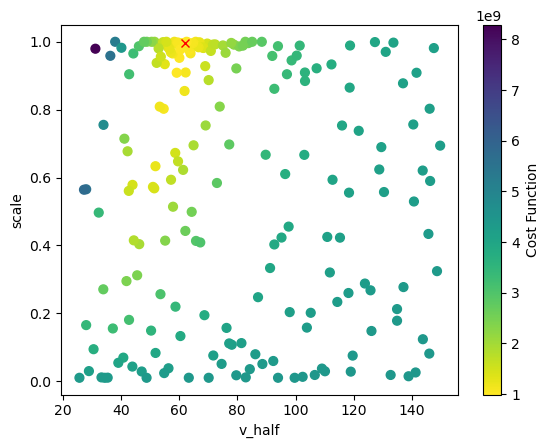

In [14]:
bayes_output.plot_p_space(x="v_half", y="scale")

In [15]:
p_space_df.drop(columns='Cost Function').iloc[1,:].to_dict()

{'scale': 1.0, 'v_half': 62.596215652392985}

## Analyze the Calibration

Now that we obtained a calibration result, we should investigate it further.
The tasks of evaluating results and plotting them is simplified by the `OutputEvaluator`.
It takes the input and output of a calibration task as parameters.
Let's start by plotting the optimized impact function:

<Axes: title={'center': 'TC 1: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

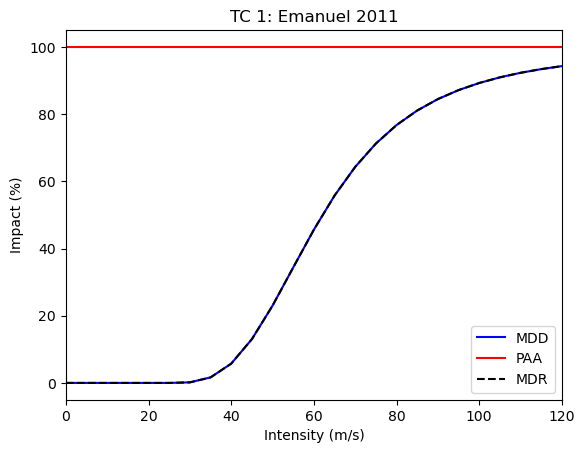

In [16]:
from climada.util.calibrate import OutputEvaluator

output_eval = OutputEvaluator(input, bayes_output)
output_eval.plot_impf_set()

Here we show how the variability in parameter combinations with similar cost function values (as seen in the plot of the parameter space) translate to varying impact functions. In addition, the hazard value distribution is shown. Together this provides an intuitive overview regarding the robustness of the optimization, given the chosen cost function. It does NOT provide a view of the sampling uncertainty (as e.g. bootstrapping or cross-validation) NOR of the suitability of the cost function which is chosen by the user.

<Axes: xlabel='Intensity (m/s)', ylabel='Mean Damage Ratio (MDR) in %'>

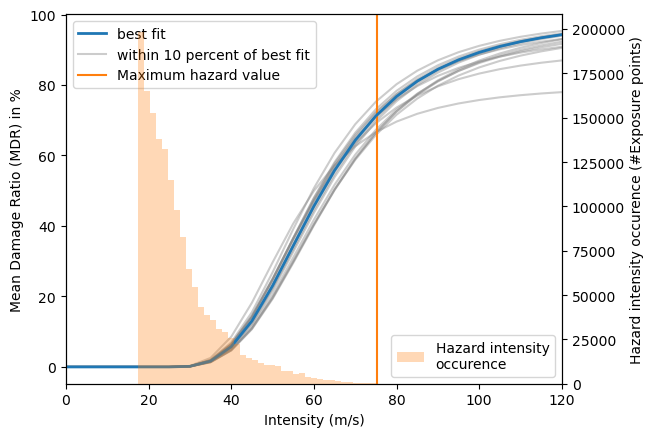

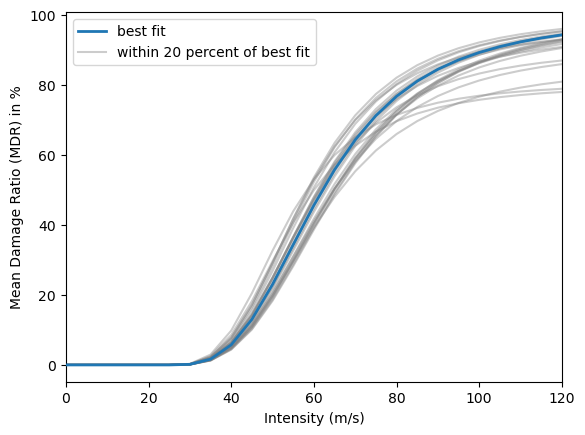

In [34]:
#Plot the impact function variability
output_eval.plot_impf_variability(cost_func_diff=0.1)
output_eval.plot_impf_variability(cost_func_diff=0.2,plot_haz=False)

The target function has limited meaning outside the calibration task.
To investigate the quality of the calibration, it is helpful to compute the impact with the impact function defined by the optimal parameters.
The `OutputEvaluator` readily computed this impact when it was created.
You can access the impact via the `OutputEvaluator.impact` attribute.

In [ ]:
import numpy as np

impact_data = output_eval.impact.impact_at_reg(exposure.gdf["region_id"])
impact_data.set_index(np.asarray(hazard.event_name), inplace=True)
impact_data

,28,44,92,132,192,212,214,388,484,630,659,662,670,796
2010176N16278,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.969526e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2010236N12341,9.513686e+06,0.000000e+00,2.351947e+07,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.841117e+07,4.633836e+06,0.000000e+00,0.000000e+00,0.000000e+00
2010257N16282,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.402395e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2010302N09306,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.122227e+06,1.644549e+06,1.335208e+05
2011233N15301,0.000000e+00,5.260807e+08,1.184680e+07,0.000000,0.000000e+00,0.000000e+00,2.615115e+04,0.000000e+00,0.000000e+00,2.831454e+08,0.000000e+00,0.000000e+00,0.000000e+00,6.704408e+07
2011279N10257,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.051491e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2012215N12313,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.080387e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2012166N09269,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.515794e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2012296N14283,0.000000e+00,5.255140e+07,0.000000e+00,0.000000,1.475877e+09,0.000000e+00,0.000000e+00,1.592644e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2014253N13260,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.079223e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


We can now compare the modelled and reported impact data on a country- or event-basis.
The `OutputEvaluator` also has methods for that.
In both of these, you can supply a transformation function with the `data_transf` argument.
This transforms the data to be plotted right before plotting.
Recall that we set the event IDs as index for the data frames.
To better interpret the results, it is useful to transform them into event names again, which are the IBTrACS IDs.
Likewise, we use the region IDs for region identification.
It might be nicer to transform these into country names before plotting.

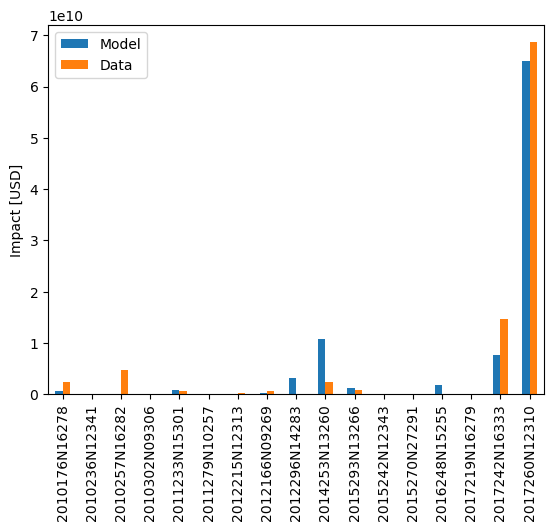

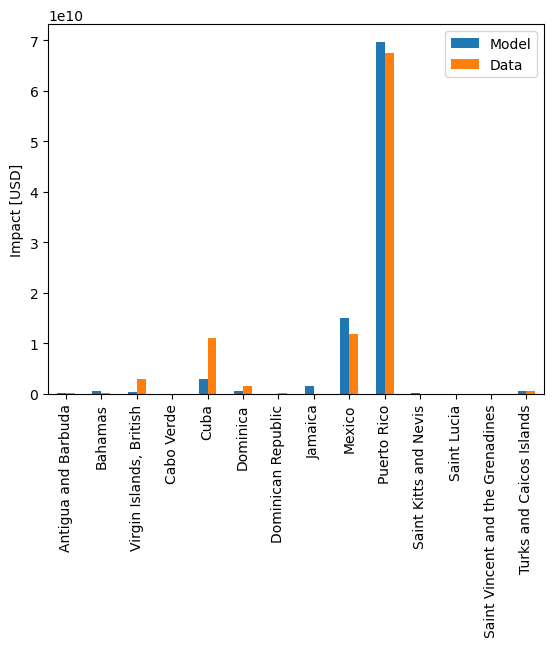

In [ ]:
import climada.util.coordinates as u_coord


def country_code_to_name(code):
    return u_coord.country_to_iso(code, representation="name")


event_id_to_name = {
    hazard.event_id[idx]: hazard.event_name[idx] for idx in range(len(hazard.event_id))
}

output_eval.plot_at_event(data_transf=lambda x: x.rename(index=event_id_to_name))
output_eval.plot_at_region(data_transf=lambda x: x.rename(index=country_code_to_name))


Finally, we can do an event- *and* country-based comparison using a heatmap using `OutputEvaluator.plot_event_region_heatmap`
Since the magnitude of the impact values may differ strongly, this method compare them on a logarithmic scale.
It divides each modelled impact by the observed impact and takes the the decadic logarithm.
The result will tell us how many orders of magnitude our model was off.
Again, the considerations for "nicer" index and columns apply.

<Axes: >

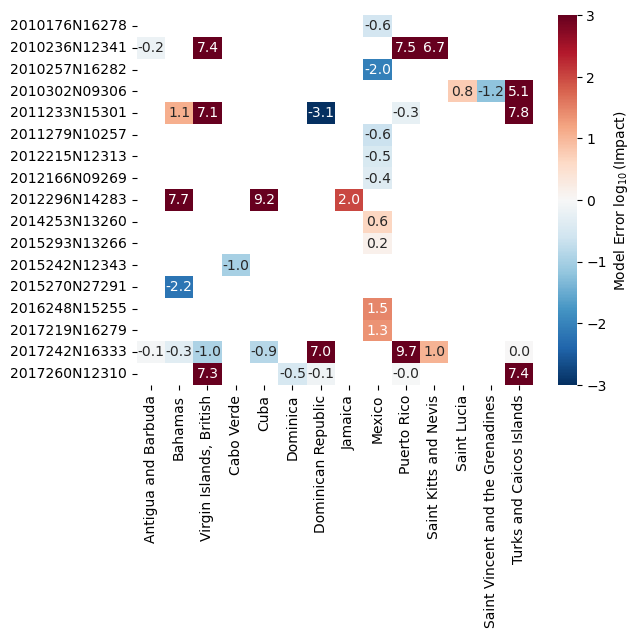

In [ ]:
output_eval.plot_event_region_heatmap(
    data_transf=lambda x: x.rename(index=event_id_to_name, columns=country_code_to_name)
)


## How to Continue

While the found impact function looks reasonable, we find that the model overestimates the impact severely for several events.
This might be due to missing data, but it is also strongly related to the choice of impact function (shape) and the particular goal of the calibration task.

The most crucial information in the calibration task is the cost function.
The RMSE measure is sensitive to the largest errors (and hence the largest impact).
Therefore, using it in the calibration minimizes the overall error, but will incorrectly capture events with impact of lower orders of magnitude.
Using a cost function based on the ratio between modelled and observed impact might increase the overall error but decrease the log-error for many events.

So we present some ideas on how to continue and/or improve the calibration:

1. Run the calibration again, but change the number of initial steps and/or iteration steps.
2. Use a different cost function, e.g., an error measure based on a ratio rather than a difference.
3. Also calibrate the `v_thresh` parameter. This requires adding constraints, because `v_thresh` < `v_half`.
4. Calibrate different impact functions for houses in Mexico and Puerto Rico within the same optimization task.
5. Employ the `ScipyMinimizeOptimizer` instead of the `BayesianOptimizer`.